References to understand interpolation, resizing, warping from a frequency domain
viewpoint:

[1] https://research.cs.wisc.edu/graphics/Courses/559-f2007/wiki/pub/Lectures/09-LiZhang-Warping.pdf

[2] https://eeweb.engineering.nyu.edu/~yao/EL6123_s16/ResizingWarping.pdf


In [1]:
import os, sys, json, pathlib, shutil, glob
import pandas as pd
import csv
import SimpleITK as sitk
import nibabel as nib
import random
import math
import numpy as np
from PIL import Image, ImageFont, ImageDraw

import scipy
from scipy.io import loadmat
from scipy import  signal

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interactive,interact, interact_manual, HBox, Layout,VBox
from IPython.display import display, clear_output

from functools import partial

from viu.io import volume
from viu.io.volume import read_volume

import torch
import torch.nn.functional as tf

#### Obtain and display an axial scan image with proper window and center

In [2]:
dcmFolder = pathlib.Path('/home/wd974888/Downloads/workingFolder/DeformationExperiment/readFormat/Patient09PB_bin_11/')
vol, res, pos = read_volume(str(dcmFolder))
print(f'dcmFolder {dcmFolder}')
print(f'vol type {type(vol)} dtype {vol.dtype} shape {vol.shape} min {np.min(vol)} max {np.max(vol)} res type {type(res)} value {res} pos type {type(pos)} value {pos}')
anAxialSlice = vol[vol.shape[0]//2, ...]
sliceMin, sliceMax, sliceHeight, sliceWidth = np.min(anAxialSlice), np.max(anAxialSlice),anAxialSlice.shape[0], anAxialSlice.shape[1]
print(f'sliceMin {sliceMin} sliceMax {sliceMax} sliceHeight {sliceHeight}, sliceWidth {sliceWidth}')

dcmFolder /home/wd974888/Downloads/workingFolder/DeformationExperiment/readFormat/Patient09PB_bin_11
vol type <class 'numpy.ndarray'> dtype float32 shape (590, 512, 512) min -4454.0 max 17616.0 res type <class 'numpy.ndarray'> value [0.9765625 0.9765625 1.       ] pos type <class 'numpy.ndarray'> value [ 1.71875000e-03 -2.19998281e+02 -5.79000000e+01]
sliceMin -1287.0 sliceMax 2574.0 sliceHeight 512, sliceWidth 512


(array([1.50333e+05, 2.68120e+04, 1.52860e+04, 6.62640e+04, 2.89200e+03,
        4.08000e+02, 7.60000e+01, 3.60000e+01, 2.80000e+01, 9.00000e+00]),
 array([-1287.        ,  -900.90002441,  -514.79998779,  -128.69999695,
          257.3999939 ,   643.5       ,  1029.59997559,  1415.69995117,
         1801.80004883,  2187.89990234,  2574.        ]),
 <BarContainer object of 10 artists>)

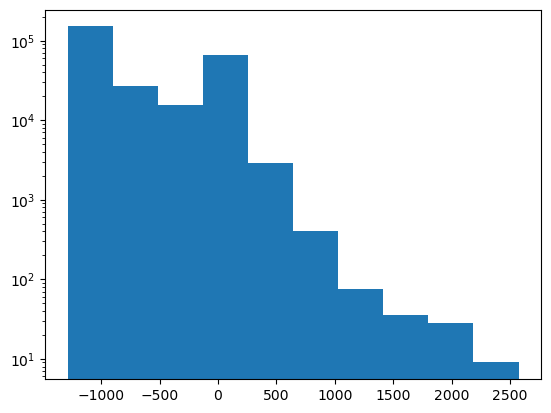

In [3]:
#https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/main/03_image_processing/04_Brightness_and_Contrast.ipynb
plt.hist(anAxialSlice.ravel(), log=True)

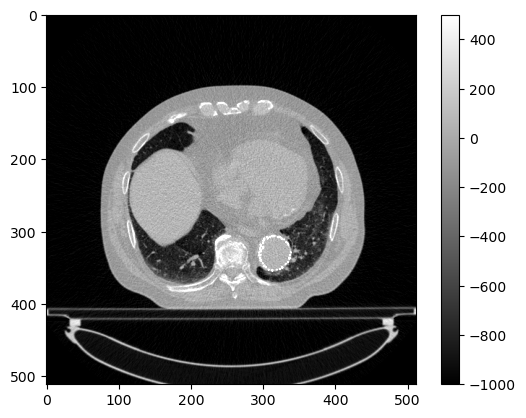

In [4]:
anAxialSlice = torch.from_numpy(anAxialSlice)
plt.imshow(anAxialSlice, cmap='gray', vmin=-1000, vmax=500)
plt.colorbar()

#### Generate affine matrix, inverse affine matrix and corresponding dense DVFs

In [5]:
# build rotation matrix
#To rotate an image around its center  use T(x_c, y_c) * R * T(-x_c, -y_c)
#See https://math.stackexchange.com/questions/2093314/rotation-matrix-of-rotation-around-a-point-other-than-the-origin
def getRotationMatrix(theta_deg, center_x, center_y):
    theta=(theta_deg / 180.0)*math.pi
    rot = [[math.cos(theta), -math.sin(theta), 0],
       [math.sin(theta), math.cos(theta), 0],
       [0, 0, 1]]
    center = [[1, 0, center_x],
          [0, 1, center_y],
          [0, 0, 1]]
    rot = torch.as_tensor(rot, dtype=torch.float)
    center = torch.as_tensor(center, dtype=torch.float)
    # Matrix multiplication : @ operator
    full_affine = center @ rot @ center.inverse() 
    print(f'full_affine type {full_affine.type}')
    print(f'full_affine dtype {full_affine.dtype}')
    print(f'full_affine value {full_affine}')
    print('verify that center of rotation does not change after rotation')
    center_rotation_after_rotation = full_affine @ torch.as_tensor([[center_x], [center_y],[1]], dtype=torch.float)
    print(f'original center_x: {center_x} center_y: {center_y} center_rotation_after_rotation {center_rotation_after_rotation}')
    return full_affine

theta_deg = 15.00
full_affine = getRotationMatrix(theta_deg=theta_deg, center_x=sliceWidth//2, center_y=sliceHeight//2)
inv_full_affine = getRotationMatrix(theta_deg=-theta_deg, center_x=sliceWidth//2, center_y=sliceHeight//2)

from interpol.api import affine_grid
grid = affine_grid(full_affine, [sliceHeight, sliceWidth])
print(f'grid type {type(grid)} shape {grid.shape} dtype {grid.dtype}')
inv_grid = affine_grid(inv_full_affine, [sliceHeight, sliceWidth])


full_affine type <built-in method type of Tensor object at 0x7faad85c6e00>
full_affine dtype torch.float32
full_affine value tensor([[  0.9659,  -0.2588,  74.9807],
        [  0.2588,   0.9659, -57.5347],
        [  0.0000,   0.0000,   1.0000]])
verify that center of rotation does not change after rotation
original center_x: 256 center_y: 256 center_rotation_after_rotation tensor([[256.],
        [256.],
        [  1.]])
full_affine type <built-in method type of Tensor object at 0x7faad85c6ef0>
full_affine dtype torch.float32
full_affine value tensor([[  0.9659,   0.2588, -57.5347],
        [ -0.2588,   0.9659,  74.9807],
        [  0.0000,   0.0000,   1.0000]])
verify that center of rotation does not change after rotation
original center_x: 256 center_y: 256 center_rotation_after_rotation tensor([[256.],
        [256.],
        [  1.]])
grid type <class 'torch.Tensor'> shape torch.Size([512, 512, 2]) dtype torch.float32


In [6]:
def displayGrid(grid, width, height, skipFactor, titleString):
    skip = height//skipFactor
    for i in range(0, height, skip):
        # print(f'1st slice each row: y value of the row is repeated  along row x times; 2nd slice each col: x value of the col along col repeated y times.')
        plt.plot(grid[i, :, 1], grid[i, :, 0], color='k') #i-th skpped-row: grid[i, :, 1]: x values changing, also perturbed by disp; grid[i, :, 0]: A constant y value  perturbed by disp
    plt.plot(grid[-1, :, 1], grid[-1, :, 0], color='k') # last row
    skip = width//skipFactor
    for j in range(0, width, skip):
        #print(f'1st slice each row: y value of the row is repeated  along row x times; 2nd slice each col: x value of the col along col repeated y times.')
        plt.plot(grid[:, j, 1], grid[:, j, 0], color='k') #j-th skpped-col: grid[:, j, 1]: A constant x values  perturbed by disp;  grid[j, :, 0]: y value changing, also perturbed by disp;
    plt.plot(grid[:, -1, 1], grid[:, -1, 0], color='k')# last col
    plt.axis('off')
    plt.title(titleString) #plt.title(f'Sampling grid at {theta_deg:.2f} degree')
    plt.show()

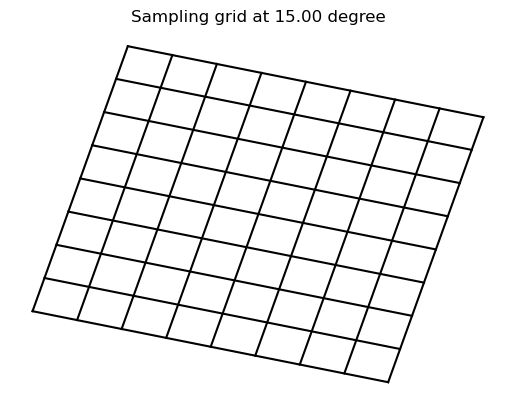

In [7]:
displayGrid(grid=grid, width=sliceWidth, height=sliceHeight, skipFactor=8, titleString=f'Sampling grid at {theta_deg:.2f} degree')

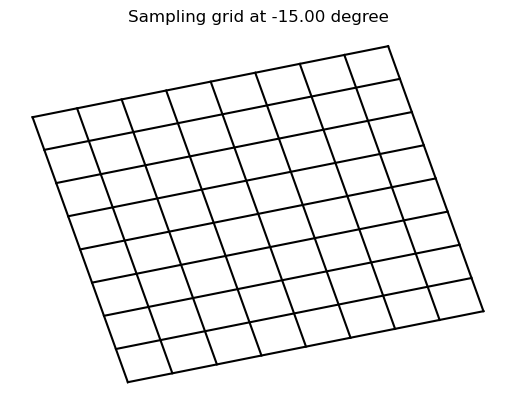

In [8]:
displayGrid(grid=inv_grid, width=sliceWidth, height=sliceHeight, skipFactor=8, titleString=f'Sampling grid at {0-theta_deg:.2f} degree')

#### Warp image 1st using the grid and then using inv_grid

In [9]:
def generateWarp(anImg, grid, inv_grid, interpolation, prefilter=False):
    import interpol
    anImg_rot = interpol.grid_pull(anImg, grid, interpolation, prefilter)
    anImg_invRot = interpol.grid_pull(anImg_rot, inv_grid, interpolation, prefilter)
    diffImg = anImg_invRot - anImg
    print(f'diffImg min: {torch.min(diffImg)} max: {torch.max(diffImg)}')
    return anImg_rot, anImg_invRot, diffImg

#interpolation=0 => nearest neighbour interpolation
# anAxialSlice_rot_intp_0, anAxialSlice_rot_invRot_intp_0, diffSlice_intp_0 =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=0, prefilter=False)
anAxialSlice_rot_intp_1, anAxialSlice_rot_invRot_intp_1, diffSlice_intp_1 =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
anAxialSlice_rot_intp_2, anAxialSlice_rot_invRot_intp_2, diffSlice_intp_2 =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=2, prefilter=False)
anAxialSlice_rot_intp_3, anAxialSlice_rot_invRot_intp_3, diffSlice_intp_3 =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
anAxialSlice_rot_intp_4, anAxialSlice_rot_invRot_intp_4, diffSlice_intp_4 =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=4, prefilter=False)

diffImg min: -973.6666259765625 max: 1273.0
diffImg min: -1051.8590087890625 max: 1273.0
diffImg min: -1208.964599609375 max: 1273.0
diffImg min: -1349.2496337890625 max: 1273.0


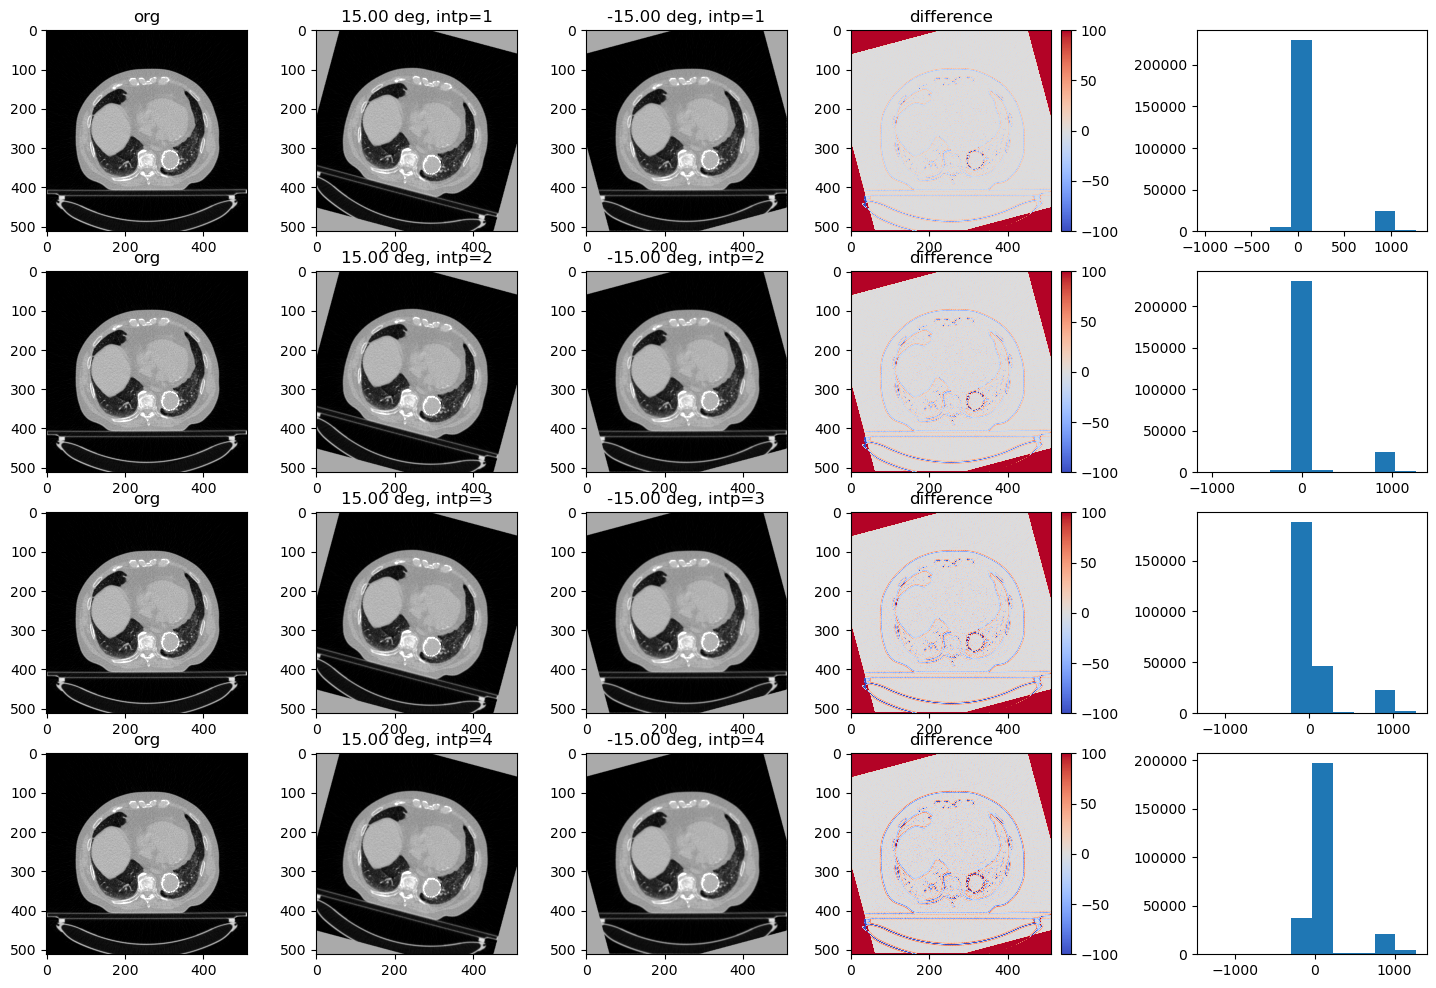

In [10]:
def plotRow(axRow, anImg, anImg_rot, anImg_invRot, diffImg, titleArray, 
            reg_cmap='gray', reg_vmin=-1000, reg_vmax=500, 
            diff_cmap='coolwarm', diff_vmin=-100, diff_vmax=100, 
            fraction=0.046, pad=0.04):
    axRow[0].imshow(anImg, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[0].title.set_text(titleArray[0])
    axRow[1].imshow(anImg_rot, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[1].title.set_text(titleArray[1])
    axRow[2].imshow(anImg_invRot, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[2].title.set_text(titleArray[2])
    d_im=axRow[3].imshow(diffImg, cmap=diff_cmap, vmin=diff_vmin, vmax=diff_vmax)
    axRow[3].title.set_text(titleArray[3])
    plt.colorbar(d_im, ax=axRow[3],fraction=fraction, pad=pad)
    # axRow[4].set_xticks([])
    # axRow[4].set_yticks([])
    axRow[4].set_axis_off()
    axRow[5].hist(diffImg.ravel())
    # axRow[5].title.set_text(titleArray[4])



fig, axArray = plt.subplots(4,6, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.2, 1]})
titleArray=['org',f'{theta_deg:.2f} deg, intp=1',f'-{theta_deg:.2f} deg, intp=1', 'difference']
plotRow(axRow=axArray[0,:], anImg=anAxialSlice, anImg_rot=anAxialSlice_rot_intp_1, anImg_invRot=anAxialSlice_rot_invRot_intp_1, diffImg=diffSlice_intp_1, titleArray=titleArray)
titleArray=['org',f'{theta_deg:.2f} deg, intp=2',f'-{theta_deg:.2f} deg, intp=2', 'difference']
plotRow(axRow=axArray[1,:], anImg=anAxialSlice, anImg_rot=anAxialSlice_rot_intp_2, anImg_invRot=anAxialSlice_rot_invRot_intp_2, diffImg=diffSlice_intp_2, titleArray=titleArray)
titleArray=['org',f'{theta_deg:.2f} deg, intp=3',f'-{theta_deg:.2f} deg, intp=3', 'difference']
plotRow(axRow=axArray[2,:], anImg=anAxialSlice, anImg_rot=anAxialSlice_rot_intp_3, anImg_invRot=anAxialSlice_rot_invRot_intp_3, diffImg=diffSlice_intp_3, titleArray=titleArray)
titleArray=['org',f'{theta_deg:.2f} deg, intp=4',f'-{theta_deg:.2f} deg, intp=4', 'difference']
plotRow(axRow=axArray[3,:], anImg=anAxialSlice, anImg_rot=anAxialSlice_rot_intp_4, anImg_invRot=anAxialSlice_rot_invRot_intp_4, diffImg=diffSlice_intp_4, titleArray=titleArray)
plt.show()


#### Why the  error on the edges increases with interpolation order

My understanding so far : During rotation, interpolation is being applied, 
which blurs the image. Higher the order of interpolation, smoother is the image and larger is the
error on the edge. To verify this, using the same interpolation order, we rotate and reverse-rotate
the image multiple times and show that in the difference image error increase in the edge based on
number of rotation and reverse-rotation operations.

https://photo.stackexchange.com/questions/41996/is-rotation-an-intrinsic-lossy-operation-for-angles-not-multiple-of-90-degrees

https://www.cambridgeincolour.com/tutorials/image-interpolation.htm


https://dsp.stackexchange.com/questions/38310/when-is-cubic-spline-interpolation-better-than-an-interpolating-polynomial

https://en.wikipedia.org/wiki/Runge's_phenomenon

https://dsp.stackexchange.com/questions/10927/higher-order-spline-interpolation


#### Some edge directed / edge preserving  interpolation algorithms:

https://www4.comp.polyu.edu.hk/~cslzhang/paper/TIP_06_Aug.pdf

Preserving edge structures is a challenge to image interpolation algorithms that reconstruct a high-resolution image from a low-resolution counterpart. We propose a new edge-guided nonlinear interpolation technique through directional filtering and data fusion. For a pixel to be interpolated, two observation sets are defined in two orthogonal directions, and each set produces an estimate of the pixel value. These directional estimates, modeled as different noisy measurements of the missing pixel are fused by the linear minimum mean square-error estimation (LMMSE) technique into a more robust estimate, using the statistics of the two observation sets. We also present a simplified version of the LMMSE-based interpolation algorithm to reduce computational cost without sacrificing much the interpolation performance. Experiments show that the new interpolation techniques can preserve edge sharpness and reduce ringing artifacts.

Edge directed interpolation (EDI):

https://chiranjivi.tripod.com/EDITut.html

Interpolation algorithms that aim to preserve edge structures are computationally more complex. Edge directed interpolation algorithms maintain features that originally existed rather than making the image all blurry when it's scaled up. The idea is to make sure that the image is NOT smooth perpendicular to edges and it IS smooth parallel to edges.
Li and Orchard [6] proposed the edge directed interpolation algorithm (NEDI), in which missing pixels are interpolated based on the estimated covariance of the high resolution (HR) image from the covariance of the low resolution (LR) image. Ketan and Oscar [7] employed an autoregressive method using Gauss Seidel optimisation that relies on both LR and HR pixels. Jaiswal and Jakhetiya [8] presented an algorithm based on downsampling and using least squares estimation. Jaiswal and Kumar’s algorithm [9] is less complex and based on a set of predictors; however these predictors do not adapt well to all types of images. Oscar and Chan [10] suggested a content adaptive interpolation scheme which is computationally simple but fails to give sufficiently high image quality.

[6] X. Li and M. T. Orchard, “New edge-directed interpolation,” Image Processing, IEEE Transactions on, vol. 10, no. 10, pp. 1521–1527, 2001.

[7] K. Tang, O. C. Au, L. Fang, Z. Yu, and Y. Guo, “Image interpolation using autoregressive model and gauss-seidel optimization,” in Image and Graphics (ICIG), 2011 Sixth International Conference on. IEEE, 2011, pp. 66–69.

[8] S. P. Jaiswal, V. Jakhetiya, and A. K. Tiwari, “An efficient image interpolation algorithm based upon the switching and self learned characteristics for natural images,” in Circuits and Systems (ISCAS), 2011 IEEE International Symposium on. IEEE, 2011, pp. 861–864.

[9] S. Prasad Jaiswal, V. Jakhetiya, A. Kumar, and A. K. Tiwari, “A low complex context adaptive image interpolation algorithm for real time applications,” in Instrumentation and Measurement Technology Conference (I2MTC), 2012 IEEE International. IEEE, 2012, pp. 969–972.

[10] T.-W. Chan, O. C. Au, T.-S. Chong, and W.-S. Chau, “A novel content adaptive interpolation,” in Circuits and Systems, 2005. ISCAS 2005. IEEE International Symposium on. IEEE, 2005, pp. 6260–6263.


https://www3.cs.stonybrook.edu/~aykumar/img/portfolio/eight.pdf

In this algorithm, interpolation is carred out based on  both pixel location as well as "inverse gradient" weights.


https://ww3.math.ucla.edu/camreport/cam11-03.pdf

Here, a piecewise hyperbolic operator is proposed  for rapid upsampling of natural images. The operator uses a slope limiter scheme that conveniently lends itself to higher-order approximations and is responsible for restricting spatial oscillations arising due to the edges and sharp details in the image. As a consequence the upsampled image not only exhibits enhanced edges, and discontinuities across boundaries, but also preserves smoothly varying features in images. Experimental results show an improvement in the PSNR compared to typical cubic, and spline-based interpolation approaches.

https://chiranjivi.tripod.com/EDITut.html

The idea is to make sure that the image is NOT smooth perpendicular to edges and it IS smooth parallel to edges.


https://ww3.math.ucla.edu/camreport/cam11-03.pdf

We propose a novel piecewise hyperbolic operator for rapid upsampling of natural images. The operator uses a slope limiter scheme that conveniently lends itself to higher-order approximations and is responsible for restricting spatial oscillations arising due to the edges and sharp details in the image. As a consequence the upsampled image not only exhibits enhanced edges, and discontinuities across boundaries, but also preserves smoothly varying features in images. Experimental results show an improvement in the PSNR compared to typical cubic, and spline-based interpolation approaches.

https://www3.cs.stonybrook.edu/~aykumar/img/portfolio/eight.pdf

Method based on pixel location and inverse gradient.

In [11]:
#First order interpolation, rotation+reverse rotation 1-5  times  No pre-filtering
_, anAxialSlice_rot_invRot_intp_1_n_1, _ =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
diffSlice_intp_1_n_1 = anAxialSlice_rot_invRot_intp_1_n_1 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_1_n_2, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_1_n_1, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
diffSlice_intp_1_n_2 = anAxialSlice_rot_invRot_intp_1_n_2 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_1_n_3, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_1_n_2, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
diffSlice_intp_1_n_3 = anAxialSlice_rot_invRot_intp_1_n_3 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_1_n_4, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_1_n_3, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
diffSlice_intp_1_n_4 = anAxialSlice_rot_invRot_intp_1_n_4 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_1_n_5, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_1_n_4, grid=grid, inv_grid=inv_grid, interpolation=1, prefilter=False)
diffSlice_intp_1_n_5 = anAxialSlice_rot_invRot_intp_1_n_5 - anAxialSlice

#Third order interpolation, rotation+reverse rotation 1-5  times No prefiltering
_, anAxialSlice_rot_invRot_intp_3_n_1, _ =  generateWarp(anImg=anAxialSlice, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
diffSlice_intp_3_n_1 = anAxialSlice_rot_invRot_intp_3_n_1 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_3_n_2, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_3_n_1, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
diffSlice_intp_3_n_2 = anAxialSlice_rot_invRot_intp_3_n_2 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_3_n_3, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_3_n_2, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
diffSlice_intp_3_n_3 = anAxialSlice_rot_invRot_intp_3_n_3 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_3_n_4, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_3_n_3, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
diffSlice_intp_3_n_4 = anAxialSlice_rot_invRot_intp_3_n_4 - anAxialSlice
_, anAxialSlice_rot_invRot_intp_3_n_5, _ =  generateWarp(anImg=anAxialSlice_rot_invRot_intp_3_n_4, grid=grid, inv_grid=inv_grid, interpolation=3, prefilter=False)
diffSlice_intp_3_n_5 = anAxialSlice_rot_invRot_intp_3_n_5 - anAxialSlice


diffImg min: -973.6666259765625 max: 1273.0
diffImg min: -415.47802734375 max: 363.85101318359375
diffImg min: -246.4730224609375 max: 179.298583984375
diffImg min: -171.798828125 max: 120.65020751953125
diffImg min: -137.55224609375 max: 88.37921142578125
diffImg min: -1208.964599609375 max: 1273.0
diffImg min: -444.14154052734375 max: 340.9010009765625
diffImg min: -231.89434814453125 max: 152.69329833984375
diffImg min: -142.19467163085938 max: 105.344482421875
diffImg min: -95.3104248046875 max: 83.06634521484375


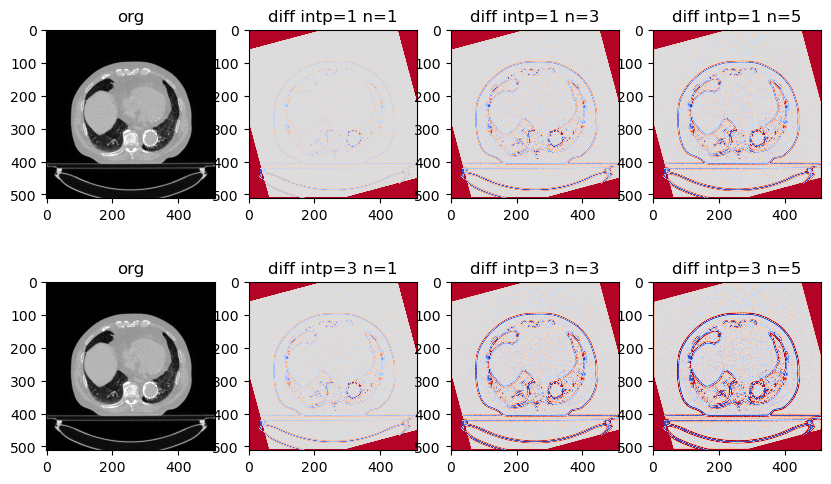

In [12]:
def plotDiffRow(axRow, anImg, diffImg_n_1, diffImg_n_2, diffImg_n_3, titleArray, 
            reg_cmap='gray', reg_vmin=-1000, reg_vmax=500, 
            diff_cmap='coolwarm', diff_vmin=-100, diff_vmax=100, 
            fraction=0.046, pad=0.04):
    axRow[0].imshow(anImg, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[0].title.set_text(titleArray[0])
    axRow[1].imshow(diffImg_n_1, cmap=diff_cmap, vmin=diff_vmin, vmax=diff_vmax)
    axRow[1].title.set_text(titleArray[1])
    axRow[2].imshow(diffImg_n_2, cmap=diff_cmap, vmin=diff_vmin, vmax=diff_vmax)
    axRow[2].title.set_text(titleArray[2])
    axRow[3].imshow(diffImg_n_3, cmap=diff_cmap, vmin=diff_vmin, vmax=diff_vmax)
    axRow[3].title.set_text(titleArray[3])

fig, axArray = plt.subplots(2,4, figsize=(10, 6))
titleArray=['org',f'diff intp=1 n=1',f'diff intp=1 n=3', f'diff intp=1 n=5']
plotDiffRow(axRow=axArray[0,:], anImg=anAxialSlice, diffImg_n_1=diffSlice_intp_1_n_1, diffImg_n_2=diffSlice_intp_1_n_3, diffImg_n_3=diffSlice_intp_1_n_5, titleArray=titleArray)
titleArray=['org',f'diff intp=3 n=1',f'diff intp=3 n=3', f'diff intp=3 n=5']
plotDiffRow(axRow=axArray[1,:], anImg=anAxialSlice,    diffImg_n_1=diffSlice_intp_3_n_1,     diffImg_n_2=diffSlice_intp_3_n_3,     diffImg_n_3=diffSlice_intp_3_n_5, titleArray=titleArray)
# titleArray=['org',f'diff intp=3 n=1 WPF',f'diff intp=3 n=3 WPF', f'diff intp=3 n=5 WPF']
# plotDiffRow(axRow=axArray[1,:], anImg=anAxialSlice, diffImg_n_1=diffSlice_intp_3_n_1_WPF, diffImg_n_2=diffSlice_intp_3_n_3_WPF, diffImg_n_3=diffSlice_intp_3_n_5_WPF, titleArray=titleArray)

#### Use prefilter to avoid blurring due to rotation

 https://dannyruijters.nl/docs/cudaPrefilter3.pdf

 https://github.com/DannyRuijters/CubicInterpolationCUDA

 

In [13]:
import interpol

numRotations =  round(360 / theta_deg)
print(f'numRotations {numRotations}')
interpolation = 'cubic'
bound = 'zero'

srcImg = anAxialSlice
for count in range(numRotations):
    dstImage =  interpol.grid_pull(input=srcImg, grid=grid, interpolation=interpolation, bound=bound,extrapolate=False, prefilter=False)
    srcImg=dstImage
rotImg_noPreF = dstImage
diffImg_noPreF = rotImg_noPreF - anAxialSlice

srcImg = anAxialSlice
for count in range(numRotations):
    dstImage =  interpol.grid_pull(input=srcImg, grid=grid, interpolation=interpolation, bound=bound,extrapolate=False, prefilter=True)
    srcImg=dstImage
rotImg_withPreF = dstImage
diffImg_withPreF = rotImg_withPreF - anAxialSlice

numRotations 24


/opt/conda/envs/clone2MMIPython/lib/python3.9/site-packages/interpol/autograd.py:287: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/third_party/nvfuser/csrc/parser.cpp:3820.)
  output = spline_coeff_nd(input, *opt)
/opt/conda/envs/clone2MMIPython/lib/python3.9/site-packages/interpol/autograd.py:287: UserWarning: operator() profile_node %258 : int[] = prim::profile_ivalue(%permutation.21)
 does not have profile information (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  output = spline_coeff_nd(input, *opt)


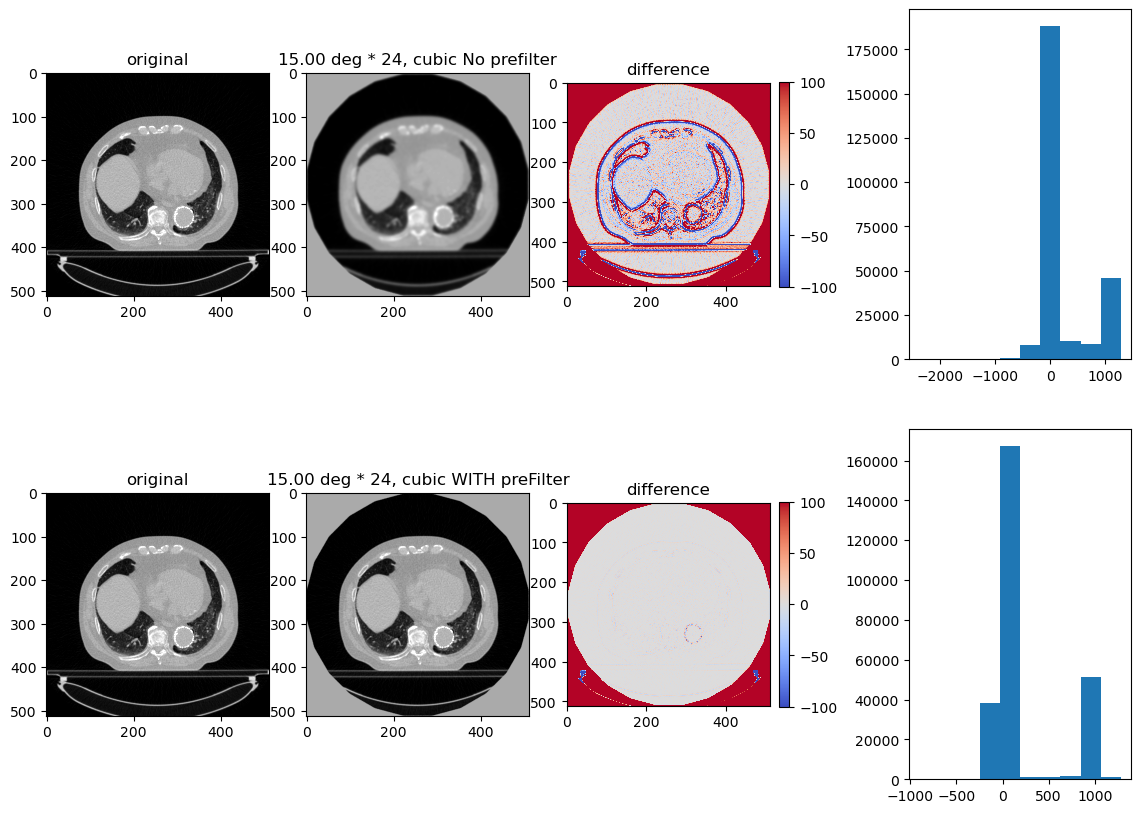

In [14]:
def plotRowShowingPrefilterEffect(axRow, anImg, anImg_rot, diffImg, titleArray, 
            reg_cmap='gray', reg_vmin=-1000, reg_vmax=500, 
            diff_cmap='coolwarm', diff_vmin=-100, diff_vmax=100, 
            fraction=0.046, pad=0.04):
    axRow[0].imshow(anImg, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[0].title.set_text(titleArray[0])
    axRow[1].imshow(anImg_rot, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
    axRow[1].title.set_text(titleArray[1])
    d_im=axRow[2].imshow(diffImg, cmap=diff_cmap, vmin=diff_vmin, vmax=diff_vmax)
    axRow[2].title.set_text(titleArray[2])
    plt.colorbar(d_im, ax=axRow[2],fraction=fraction, pad=pad)

    axRow[3].set_axis_off()

    axRow[4].hist(diffImg.ravel())

fig, axArray = plt.subplots(2,5, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.2, 1]})
titleArray=['original',f'{theta_deg:.2f} deg * {numRotations:02d}, {interpolation} No prefilter', 'difference']
plotRowShowingPrefilterEffect(axRow=axArray[0,:], anImg=anAxialSlice, anImg_rot=rotImg_noPreF, diffImg=diffImg_noPreF, titleArray=titleArray)
titleArray=['original',f'{theta_deg:.2f} deg * {numRotations:02d}, {interpolation} WITH preFilter', 'difference']
plotRowShowingPrefilterEffect(axRow=axArray[1,:], anImg=anAxialSlice, anImg_rot=rotImg_withPreF, diffImg=diffImg_withPreF, titleArray=titleArray)

#### Another example

In [15]:
dcmFolder = pathlib.Path('/home/wd974888/Downloads/workingFolder/DeformationExperiment/readFormat/Patient09PB_bin_11/')
vol, res, pos = read_volume(str(dcmFolder))
print(f'dcmFolder {dcmFolder}')
print(f'vol type {type(vol)} dtype {vol.dtype} shape {vol.shape} min {np.min(vol)} max {np.max(vol)} res type {type(res)} value {res} pos type {type(pos)} value {pos}')
# anAxialSlice = vol[vol.shape[0]//2, ...]
aCoronalSlice = vol[:,vol.shape[1]//2,:]
sliceMin, sliceMax, sliceHeight, sliceWidth = np.min(aCoronalSlice), np.max(aCoronalSlice),aCoronalSlice.shape[0], aCoronalSlice.shape[1]
print(f'sliceMin {sliceMin} sliceMax {sliceMax} sliceHeight {sliceHeight}, sliceWidth {sliceWidth}')

dcmFolder /home/wd974888/Downloads/workingFolder/DeformationExperiment/readFormat/Patient09PB_bin_11
vol type <class 'numpy.ndarray'> dtype float32 shape (590, 512, 512) min -4454.0 max 17616.0 res type <class 'numpy.ndarray'> value [0.9765625 0.9765625 1.       ] pos type <class 'numpy.ndarray'> value [ 1.71875000e-03 -2.19998281e+02 -5.79000000e+01]
sliceMin -1182.0 sliceMax 5041.0 sliceHeight 590, sliceWidth 512


aCoronalSlice type <class 'numpy.ndarray'> shape (590, 512) dtype float32


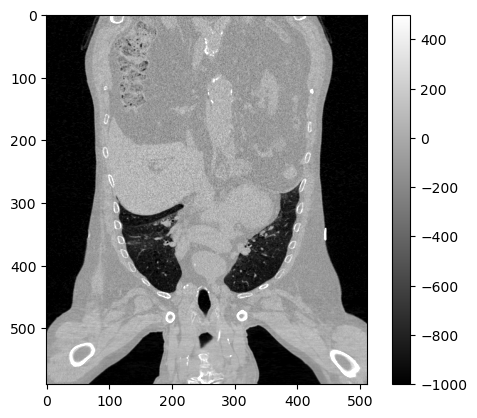

In [16]:
# aCoronalSlice = torch.from_numpy(aCoronalSlice)
print(f'aCoronalSlice type {type(aCoronalSlice)} shape {aCoronalSlice.shape} dtype {aCoronalSlice.dtype}')
plt.imshow(aCoronalSlice, cmap='gray', vmin=-1000, vmax=500)
plt.colorbar()

xPad 256 yPad 217


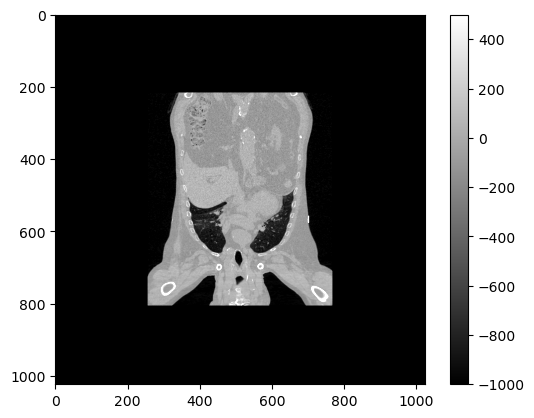

In [17]:
aSquareCoronalSlice = np.ones((1024,1024), 'float32') * sliceMin
xPad = (1024 - sliceWidth)//2
yPad = (1024 - sliceHeight)//2
print(f'xPad {xPad} yPad {yPad}')
assert 1024==2*xPad + sliceWidth, 'Problen with x padding'
assert 1024==2*yPad + sliceHeight, 'Problen with y padding'
aSquareCoronalSlice[yPad:yPad+sliceHeight, xPad:xPad+sliceWidth] = aCoronalSlice
plt.imshow(aSquareCoronalSlice, cmap='gray', vmin=-1000, vmax=500)
plt.colorbar()

In [18]:
#### Rewrite coronal slice
aCoronalSlice_org=aCoronalSlice
aCoronalSlice=aSquareCoronalSlice
sliceMin, sliceMax, sliceHeight, sliceWidth = np.min(aCoronalSlice), np.max(aCoronalSlice),aCoronalSlice.shape[0], aCoronalSlice.shape[1]
print(f'sliceMin {sliceMin} sliceMax {sliceMax} sliceHeight {sliceHeight}, sliceWidth {sliceWidth}')

sliceMin -1182.0 sliceMax 5041.0 sliceHeight 1024, sliceWidth 1024


In [19]:
aCoronalSlice_org = torch.from_numpy(aCoronalSlice_org)
aCoronalSlice = torch.from_numpy(aCoronalSlice)

In [21]:
import interpol
from interpol.api import affine_grid

theta_deg = 30.00
full_affine = getRotationMatrix(theta_deg=theta_deg, center_x=sliceWidth//2, center_y=sliceHeight//2)

grid = affine_grid(full_affine, [sliceHeight, sliceWidth])
print(f'grid type {type(grid)} shape {grid.shape} dtype {grid.dtype}')

numRotations =  round(360 / theta_deg)
print(f'numRotations {numRotations}')
interpolation = 'cubic'
bound = 'zero'

srcImg = aCoronalSlice
for count in range(numRotations):
    dstImage =  interpol.grid_pull(input=srcImg, grid=grid, interpolation=interpolation, bound=bound,extrapolate=False, prefilter=False)
    srcImg=dstImage
rotImg_noPreF = dstImage
diffImg_noPreF = rotImg_noPreF - aCoronalSlice

srcImg = aCoronalSlice
for count in range(numRotations):
    dstImage =  interpol.grid_pull(input=srcImg, grid=grid, interpolation=interpolation, bound=bound,extrapolate=False, prefilter=True)
    srcImg=dstImage
rotImg_withPreF = dstImage
diffImg_withPreF = rotImg_withPreF - aCoronalSlice

full_affine type <built-in method type of Tensor object at 0x7faa8e1a1a90>
full_affine dtype torch.float32
full_affine value tensor([[   0.8660,   -0.5000,  324.5950],
        [   0.5000,    0.8660, -187.4050],
        [   0.0000,    0.0000,    1.0000]])
verify that center of rotation does not change after rotation
original center_x: 512 center_y: 512 center_rotation_after_rotation tensor([[512.],
        [512.],
        [  1.]])
grid type <class 'torch.Tensor'> shape torch.Size([1024, 1024, 2]) dtype torch.float32
numRotations 12


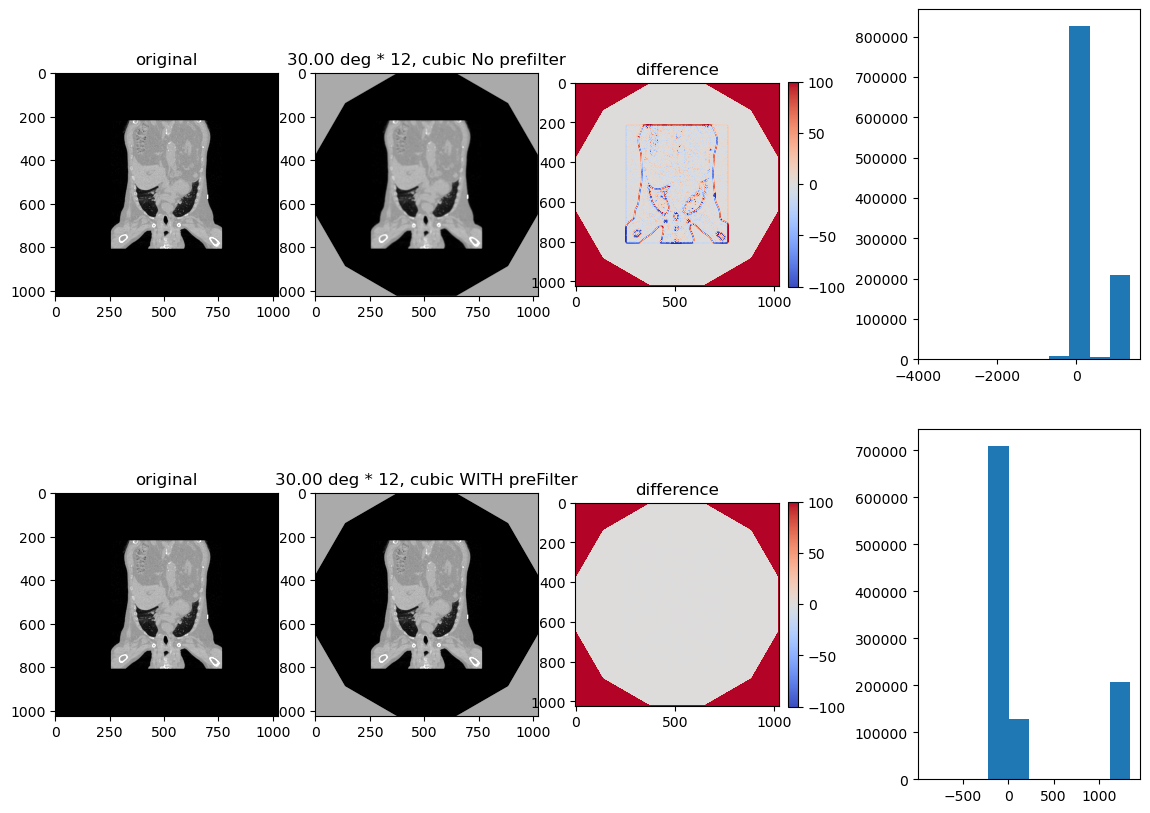

In [22]:
fig, axArray = plt.subplots(2,5, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.2, 1]})
titleArray=['original',f'{theta_deg:.2f} deg * {numRotations:02d}, {interpolation} No prefilter', 'difference']
plotRowShowingPrefilterEffect(axRow=axArray[0,:], anImg=aCoronalSlice, anImg_rot=rotImg_noPreF, diffImg=diffImg_noPreF, titleArray=titleArray)
titleArray=['original',f'{theta_deg:.2f} deg * {numRotations:02d}, {interpolation} WITH preFilter', 'difference']
plotRowShowingPrefilterEffect(axRow=axArray[1,:], anImg=aCoronalSlice, anImg_rot=rotImg_withPreF, diffImg=diffImg_withPreF, titleArray=titleArray)